##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build, train and evaluate models with TensorFlow Decision Forests

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/beginner_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


## Introduction

Decision Forests (DF) are a large family of Machine Learning algorithms for
supervised classification, regression and ranking. As the name suggests, DFs use
decision trees as a building block. Today, the two most popular DF training
algorithms are [Random Forests](https://en.wikipedia.org/wiki/Random_forest) and
[Gradient Boosted Decision Trees](https://en.wikipedia.org/wiki/Gradient_boosting). Both algorithms are ensemble techniques that use multiple decision trees, but differ on how they do it.

TensorFlow Decision Forests (TF-DF) is a library for the training,
evaluation, interpretation and inference of Decision Forest models.

In this tutorial, you will learn how to:

1.  Train a binary classification Random Forest on a dataset containing numerical, categorical and missing features.
1.  Evaluate the model on a test dataset.
1.  Prepare the model for
    [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).
1.  Examine the overall structure of the model and the importance of each feature.
1.  Re-train the model with a different learning algorithm (Gradient Boosted Decision Trees).
1.  Use a different set of input features.
1.  Change the hyperparameters of the model.
1.  Preprocess the features.
1.  Train a model for regression.
1.  Train a model for ranking.

Detailed documentation is available in the [user manual](https://github.com/tensorflow/decision-forests/tree/main/documentation).
The [example directory](https://github.com/tensorflow/decision-forests/tree/main/examples) contains other end-to-end examples.

## Installing TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [2]:
!pip install tensorflow_decision_forests

  Using cached tensorflow_decision_forests-0.2.7-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)


  Using cached wurlitzer-3.0.2-py3-none-any.whl (7.3 kB)


  Using cached MarkupSafe-2.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)


  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [3]:
!pip install wurlitzer

## Importing libraries

In [4]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

The hidden code cell limits the output height in colab.


In [5]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [6]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.2.7


## Training a Random Forest model

In this section, we train, evaluate, analyse and export a binary classification Random Forest trained on the [Palmer's Penguins](https://allisonhorst.github.io/palmerpenguins/articles/intro.html) dataset.

<center>
<img src="https://allisonhorst.github.io/palmerpenguins/man/figures/palmerpenguins.png" width="150"/></center>

**Note:** The dataset was exported to a csv file without pre-processing: `library(palmerpenguins); write.csv(penguins, file="penguins.csv", quote=F, row.names=F)`. 

### Load the dataset and convert it in a tf.Dataset

This dataset is very small (300 examples) and stored as a .csv-like file. Therefore, use Pandas to load it.

**Note:** Pandas is practical as you don't have to type in name of the input features to load them. For larger datasets (>1M examples), using the
[TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to read the files may be better suited.

Let's assemble the dataset into a csv file (i.e. add the header), and load it:

In [7]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


The dataset contains a mix of numerical (e.g. `bill_depth_mm`), categorical
(e.g. `island`) and missing features. TF-DF supports all these feature types natively (differently than NN based models), therefore there is no need for preprocessing in the form of one-hot encoding, normalization or extra `is_present` feature.

Labels are a bit different: Keras metrics expect integers. The label (`species`) is stored as a string, so let's convert it into an integer.

In [8]:
# Encode the categorical labels as integers.
#
# Details:
# This stage is necessary if your classification label is represented as a
# string since Keras expects integer classification labels.
# When using `pd_dataframe_to_tf_dataset` (see below), this step can be skipped.

# Name of the label column.
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


Next split the dataset into training and testing:

In [9]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

241 examples in training, 103 examples for testing.


And finally, convert the pandas dataframe (`pd.Dataframe`) into tensorflow datasets (`tf.data.Dataset`):

In [10]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


**Notes:** Recall that `pd_dataframe_to_tf_dataset` converts string labels to integers if necessary.

If you want to create the `tf.data.Dataset` yourself, there are a couple of things to remember:

- The learning algorithms work with a one-epoch dataset and without shuffling.
- The batch size does not impact the training algorithm, but a small value might slow down reading the dataset.


### Train the model

In [11]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel()

# Train the model.
model_1.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpity0p325 as temporary training directory


Reading training dataset...


Training dataset read in 0:00:03.555543. Found 241 examples.


Training model...


Model trained in 0:00:00.040050


Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmpity0p325/model/ with prefix 8546ce4ceef5421b
[INFO abstract_model.cc:1248] Engine "RandomForestGeneric" built
[INFO kernel.cc:1022] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model compiled.


### Remarks

-   No input features are specified. Therefore, all the columns will be used as
    input features except for the label. The feature used by the model are shown
    in the training logs and in the `model.summary()`.
-   DFs consume natively numerical, categorical, categorical-set features and
    missing-values. Numerical features do not need to be normalized. Categorical
    string values do not need to be encoded in a dictionary.
-   No training hyper-parameters are specified. Therefore the default
    hyper-parameters will be used. Default hyper-parameters provide
    reasonable results in most situations.
-   Calling `compile` on the model before the `fit` is optional. Compile can be
    used to provide extra evaluation metrics.
-   Training algorithms do not need validation datasets. If a validation dataset
    is provided, it will only be used to show metrics.
-   Add a `verbose` argument to `RandomForestModel` to control the amount of
    displayed training logs. Set `verbose=0` to hide most of the logs. Set 
    `verbose=2` to show all the logs.

**Note:** A *Categorical-Set* feature is composed of a set of categorical values (while a *Categorical* is only one value). More details and examples are given later.

## Evaluate the model

Let's evaluate our model on the test dataset.

In [12]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9709

1/1 [==============================] - 0s 325ms/step - loss: 0.0000e+00 - accuracy: 0.9709



loss: 0.0000
accuracy: 0.9709


**Remark:** The test accuracy (0.86514) is close to the Out-of-bag accuracy
(0.8672) shown in the training logs.

See the **Model Self Evaluation** section below for more evaluation methods.

## Prepare this model for TensorFlow Serving.

Export the model to the SavedModel format for later re-use e.g.
[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).


In [13]:
model_1.save("/tmp/my_saved_model")

INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


## Plot the model

Plotting a decision tree and following the first branches helps learning about decision forests. In some cases, plotting a model can even be used for debugging.

Because of the difference in the way they are trained, some models are more interesting to plan than others. Because of the noise injected during training and the depth of the trees, plotting Random Forest is less informative than plotting a CART or the first tree of a Gradient Boosted Tree.

Never the less, let's plot the first tree of our Random Forest model:

In [14]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

The root node on the left contains the first condition (`bill_depth_mm >= 16.55`), number of examples (240) and label distribution (the red-blue-green bar).

Examples that evaluates true to `bill_depth_mm >= 16.55` are branched to the green path. The other ones are branched to the red path.

The deeper the node, the more `pure` they become i.e. the label distribution is biased toward a subset of classes. 

**Note:** Over the mouse on top of the plot for details.

## Model structure and feature importance

The overall structure of the model is show with `.summary()`. You will see:

-   **Type**: The learning algorithm used to train the model (`Random Forest` in
    our case).
-   **Task**: The problem solved by the model (`Classification` in our case).
-   **Input Features**: The input features of the model.
-   **Variable Importance**: Different measures of the importance of each
    feature for the model.
-   **Out-of-bag evaluation**: The out-of-bag evaluation of the model. This is a
    cheap and efficient alternative to cross-validation.
-   **Number of {trees, nodes} and other metrics**: Statistics about the
    structure of the decisions forests.

**Remark:** The summary's content depends on the learning algorithm (e.g.
Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g.
the *mean-decrease-in-accuracy* variable importance can be disabled in the
hyper-parameters).

In [15]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


Total params: 1


Trainable params: 0


Non-trainable params: 1


_________________________________________________________________


Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  2.989035 ################
    2.              "year"  2.966493 ###############
    3.               "sex"  2.955250 ###############
    4.       "body_mass_g"  2.426491 ###########
    5.     "bill_depth_mm"  2.355057 ##########
    6.            "island"  2.043795 #######
    7. "flipper_length_mm"  1.278457 #
    8.    "bill_length_mm"  1.135782 

Variable Importance: NUM_AS_ROOT:
    1. "flipper_length_mm" 139.000000 ################
    2.    "bill_length_mm" 111.000000 ############
    3.     "bill_depth_mm" 27.000000 ##
    4.       "body_mass_g" 14.000000 
    5.            "island"  9.000000 

Variable Importance: NUM_NODES:
    1.    "bill_length_mm" 606.000000 ################
    2. "flipper_length_mm" 354.000000 #########
    3.     "bil

The information in ``summary`` are all available programatically using the model inspector:

In [16]:
# The input features
model_1.make_inspector().features()

["bill_depth_mm" (1; #0),
 "bill_length_mm" (1; #1),
 "body_mass_g" (1; #2),
 "flipper_length_mm" (1; #3),
 "island" (4; #4),
 "sex" (4; #5),
 "year" (1; #6)]

In [17]:
# The feature importances
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("flipper_length_mm" (1; #3), 139.0),
  ("bill_length_mm" (1; #1), 111.0),
  ("bill_depth_mm" (1; #0), 27.0),
  ("body_mass_g" (1; #2), 14.0),
  ("island" (4; #4), 9.0)],
 'MEAN_MIN_DEPTH': [("__LABEL" (4; #7), 2.9890352332852292),
  ("year" (1; #6), 2.96649266474266),
  ("sex" (4; #5), 2.9552498797498767),
  ("body_mass_g" (1; #2), 2.4264906204906187),
  ("bill_depth_mm" (1; #0), 2.355057239057239),
  ("island" (4; #4), 2.0437953342953343),
  ("flipper_length_mm" (1; #3), 1.2784569504569512),
  ("bill_length_mm" (1; #1), 1.1357817460317463)],
 'NUM_NODES': [("bill_length_mm" (1; #1), 606.0),
  ("flipper_length_mm" (1; #3), 354.0),
  ("bill_depth_mm" (1; #0), 278.0),
  ("island" (4; #4), 255.0),
  ("body_mass_g" (1; #2), 240.0),
  ("sex" (4; #5), 24.0),
  ("year" (1; #6), 18.0)],
 'SUM_SCORE': [("bill_length_mm" (1; #1), 28480.13391963765),
  ("flipper_length_mm" (1; #3), 22666.768785581866),
  ("island" (4; #4), 11081.008401110768),
  ("bill_depth_mm" (1; #0), 5658.83

The content of the summary and the inspector depends on the learning algorithm (`tfdf.keras.RandomForestModel` in this case) and its hyper-parameters (e.g. `compute_oob_variable_importances=True` will trigger the computation of Out-of-bag variable importances for the Random Forest learner).

## Model Self Evaluation

During training TFDF models can self evaluate even if no validation dataset is provided to the `fit()` method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation.

**Note:** While this evaluation is  computed during training, it is NOT computed on the training dataset and can be used as a low quality evaluation.

The model self evaluation is available with the inspector's `evaluation()`:

In [18]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=241, accuracy=0.970954356846473, loss=0.07552493617510524, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

## Plotting the training logs

The training logs show the quality of the model (e.g. accuracy evaluated on the out-of-bag or validation dataset) according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality.

The logs are available in multiple ways:

1. Displayed in during training if `fit()` is wrapped in `with sys_pipes():` (see example above).
1. At the end of the model summary i.e. `model.summary()` (see example above).
1. Programmatically, using the model inspector i.e. `model.make_inspector().training_logs()`.
1. Using [TensorBoard](https://www.tensorflow.org/tensorboard)

Let's try the options 2 and 3:


In [19]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=92, accuracy=0.9565217391304348, loss=1.5671152861221977, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=240, accuracy=0.9583333333333334, loss=0.5273260268693168, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=22, evaluation=Evaluation(num_examples=241, accuracy=0.9543568464730291, loss=0.0872588047286287, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=32, evaluation=Evaluation(num_examples=241, accuracy=0.9543568464730291, loss=0.08582401172068604, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=43, evaluation=Evaluation(num_examples=241, accuracy=0.9585062240663901, loss=0.08778861426280742, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=54, evaluation=Evaluation(num_examples=241, accuracy=0.9585062240663901, loss=0.08505637662415683, rmse=N

Let's plot it:

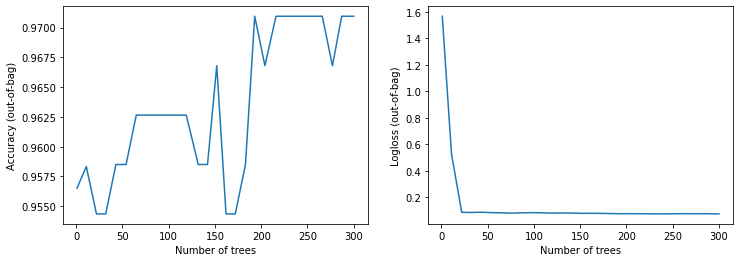

In [20]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

This dataset is small. You can see the model converging almost immediately.

Let's use TensorBoard:

In [21]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [22]:
# Clear existing results (if any)
!rm -fr "/tmp/tensorboard_logs"

In [23]:
# Export the meta-data to tensorboard.
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [ ]:
# docs_infra: no_execute
# Start a tensorboard instance.
%tensorboard --logdir "/tmp/tensorboard_logs"

<!-- <img class="tfo-display-only-on-site" src="images/beginner_tensorboard.png"/> -->


## Re-train the model with a different learning algorithm

The learning algorithm is defined by the model class. For
example, `tfdf.keras.RandomForestModel()` trains a Random Forest, while
`tfdf.keras.GradientBoostedTreesModel()` trains a Gradient Boosted Decision
Trees.

The learning algorithms are listed by calling `tfdf.keras.get_all_models()` or in the
[learner list](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

In [24]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

The description of the learning algorithms and their hyper-parameters are also available in the [API reference](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf) and builtin help:

In [25]:
# help works anywhere.
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks, it usually opens on a separate panel.
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Method resolution order:
 |      RandomForestModel
 |      tensorflow_decision_forests.keras.wrappers.RandomForestModel
 |      tensorflow_decision_forests.keras.core.CoreModel
 |      keras.engine.training.Model
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.training.tracking.autotrackable.AutoTrackable
 |      tensorflow.python.training.tracking.base.Trackable
 |      keras.utils.version_utils.LayerVersionSelector
 |      keras.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Methods inherited from tensorflow_decision_forests.keras.wrappers.RandomForestModel:
 |  
 |  __init__ = wrapper(*args, **kargs)
 |  
 |  ----------------------------------------------------------------------
 |  Sta

## Using a subset of features

The previous example did not specify the features, so all the columns were used
as input feature (except for the label). The following example shows how to
specify input features.

In [26]:
feature_1 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_2 = tfdf.keras.FeatureUsage(name="island")

all_features = [feature_1, feature_2]

# Note: This model is only trained with two features. It will not be as good as
# the one trained on all features.

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features, exclude_non_specified_features=True)

model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

Use /tmpfs/tmp/tmpoldepo9k as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.159010. Found 241 examples.


Reading validation dataset...


Num validation examples: tf.Tensor(103, shape=(), dtype=int32)


Validation dataset read in 0:00:00.223156. Found 103 examples.


Training model...


Model trained in 0:00:00.370454


Compiling model...


Model compiled.


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmpoldepo9k/model/ with prefix ec3656e312c34aa9
[INFO kernel.cc:1022] Use fast generic engine


1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9417

1/1 [==============================] - 0s 87ms/step - loss: 0.0000e+00 - accuracy: 0.9417


{'loss': 0.0, 'accuracy': 0.9417475461959839}


**Note:** As expected, the accuracy is lower than previously.

**TF-DF** attaches a **semantics** to each feature. This semantics controls how
the feature is used by the model. The following semantics are currently supported:

-   **Numerical**: Generally for quantities or counts with full ordering. For
    example, the age of a person, or the number of items in a bag. Can be a
    float or an integer. Missing values are represented with float(Nan) or with
    an empty sparse tensor.
-   **Categorical**: Generally for a type/class in finite set of possible values
    without ordering. For example, the color RED in the set {RED, BLUE, GREEN}.
    Can be a string or an integer. Missing values are represented as "" (empty
    sting), value -2 or with an empty sparse tensor.
-   **Categorical-Set**: A set of categorical values. Great to represent
    tokenized text. Can be a string or an integer in a sparse tensor or a
    ragged tensor (recommended). The order/index of each item doesn't matter.

If not specified, the semantics is inferred from the representation type and shown in the training logs:

- int, float (dense or sparse) → Numerical semantics.
- str (dense or sparse) → Categorical semantics
- int, str (ragged) → Categorical-Set semantics

In some cases, the inferred semantics is incorrect. For example: An Enum stored as an integer is semantically categorical, but it will be detected as numerical. In this case, you should specify the semantic argument in the input. The `education_num` field of the Adult dataset is classical example.

This dataset doesn't contain such a feature. However, for the demonstration, we will make the model treat the `year` as a categorical feature:

In [27]:
%set_cell_height 300

feature_1 = tfdf.keras.FeatureUsage(name="year", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_3 = tfdf.keras.FeatureUsage(name="sex")
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])

model_3.fit(x=train_ds, validation_data=test_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpgmfzgw4b as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.160803. Found 241 examples.


Reading validation dataset...


Num validation examples: tf.Tensor(103, shape=(), dtype=int32)


Validation dataset read in 0:00:00.166242. Found 103 examples.


Training model...


Model trained in 0:00:00.240958


Compiling model...


Model compiled.


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmpgmfzgw4b/model/ with prefix 0320cc93b10246c1
[INFO kernel.cc:1022] Use fast generic engine


Note that `year` is in the list of CATEGORICAL features (unlike the first run).

## Hyper-parameters

**Hyper-parameters** are parameters of the training algorithm that impact
the quality of the final model. They are specified in the model class
constructor. The list of hyper-parameters is visible with the *question mark* colab command (e.g. `?tfdf.keras.GradientBoostedTreesModel`).

Alternatively, you can find them on the [TensorFlow Decision Forest Github](https://github.com/tensorflow/decision-forests/blob/main/tensorflow_decision_forests/keras/wrappers_pre_generated.py) or the [Yggdrasil Decision Forest documentation](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

The default hyper-parameters of each algorithm matches approximatively the initial publication paper. To ensure consistancy, new features and their matching hyper-parameters are always disable by default. That's why it is a good idea to tune your hyper-parameters.

In [28]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_6.fit(x=train_ds)

Use /tmpfs/tmp/tmpywe1fd2u as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.339957. Found 241 examples.


Training model...


Model trained in 0:00:01.397824


Compiling model...


Model compiled.


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmpywe1fd2u/model/ with prefix 0fef8a922db04f14
[INFO kernel.cc:1022] Use fast generic engine


In [29]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_7.fit(x=train_ds)

Use /tmpfs/tmp/tmp6ci2x3f6 as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.191335. Found 241 examples.


Training model...

[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmp6ci2x3f6/model/ with prefix beffbccd83af4f62


Model trained in 0:00:08.485194


Compiling model...


[INFO abstract_model.cc:1248] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:1022] Use fast generic engine


Model compiled.


As new training methods are published and implemented, combinaisons of hyper-parameters can emerge as good or almost-always-better than the default parameters. To avoid changing the default hyper-parameter values these good combinaisons are indexed and available as hyper-parameter templates.

For example, the `benchmark_rank1` template is the best combinaison on our internal benchmarks. Those templates are versioned to allow training configuration stability e.g. `benchmark_rank1@v1`.

In [30]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.fit(x=train_ds)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.


 The `num_threads` constructor argument is not set and the number of CPU is os.cpu_count()=32 > 32. Setting num_threads to 32. Set num_threads manually to use more than 32 cpus.


Use /tmpfs/tmp/tmpl7ohgrv4 as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.199829. Found 241 examples.


Training model...


Model trained in 0:00:01.439038


Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmpl7ohgrv4/model/ with prefix 62da947fb04444c8
[INFO kernel.cc:1022] Use fast generic engine


Model compiled.


The available tempaltes are available with `predefined_hyperparameters`. Note that different learning algorithms have different templates, even if the name is similar.

In [31]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


## Feature Preprocessing

Pre-processing features is sometimes necessary to consume signals with complex
structures, to regularize the model or to apply transfer learning.
Pre-processing can be done in one of three ways:

1.  Preprocessing on the Pandas dataframe. This solution is easy to implement
    and generally suitable for experimentation. However, the
    pre-processing logic will not be exported in the model by `model.save()`.

2.  [Keras Preprocessing](https://keras.io/guides/preprocessing_layers/): While
    more complex than the previous solution, Keras Preprocessing is packaged in
    the model.

3.  [TensorFlow Feature Columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns):
    This API is part of the TF Estimator library (!= Keras) and planned for
    deprecation. This solution is interesting when using existing preprocessing
    code.

Note: Using [TensorFlow Hub](https://www.tensorflow.org/hub)
pre-trained embedding is often, a great way to consume text and image with
TF-DF. For example, `hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")`. See the [Intermediate tutorial](intermediate_colab.ipynb) for more details.

In the next example, pre-process the `body_mass_g` feature into `body_mass_kg = body_mass_g / 1000`. The `bill_length_mm` is consumed without pre-processing. Note that such
monotonic transformations have generally no impact on decision forest models.

In [32]:
%set_cell_height 300

body_mass_g = tf.keras.layers.Input(shape=(1,), name="body_mass_g")
body_mass_kg = body_mass_g / 1000.0

bill_length_mm = tf.keras.layers.Input(shape=(1,), name="bill_length_mm")

raw_inputs = {"body_mass_g": body_mass_g, "bill_length_mm": bill_length_mm}
processed_inputs = {"body_mass_kg": body_mass_kg, "bill_length_mm": bill_length_mm}

# "preprocessor" contains the preprocessing logic.
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# "model_4" contains both the pre-processing logic and the decision forest.
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(x=train_ds)

model_4.summary()

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpx5736l6y as temporary training directory


Reading training dataset...


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['island', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Training dataset read in 0:00:00.258396. Found 241 examples.


Training model...


Model trained in 0:00:00.036195


Compiling model...


Model compiled.


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmpx5736l6y/model/ with prefix 905dc6d35bd64ab4
[INFO kernel.cc:1022] Use fast generic engine


Model: "random_forest_model_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 model (Functional)          {'body_mass_kg': (None,   0         


                             1),                                 


                              'bill_length_mm': (None            


                             , 1)}                               


Total params: 1


Trainable params: 0


Non-trainable params: 1


_________________________________________________________________


Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	bill_length_mm
	body_mass_kg

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.        "__LABEL"  3.570771 ################
    2.   "body_mass_kg"  1.065695 ####
    3. "bill_length_mm"  0.000000 

Variable Importance: NUM_AS_ROOT:
    1. "bill_length_mm" 300.000000 

Variable Importance: NUM_NODES:
    1. "bill_length_mm" 1178.000000 ################
    2.   "body_mass_kg" 1114.000000 

Variable Importance: SUM_SCORE:
    1. "bill_length_mm" 44181.012879 ################
    2.   "body_mass_kg" 25667.896345 



Winner take all: true
Out-of-bag evaluation: accuracy:0.937759 logloss:0.461715
Number of trees: 300
Total number of nodes: 4884

Number of nodes by tree:
Count: 300 Average: 16.28 StdDev: 2.68109
Min: 9 Max: 23 Ignored: 0
----------------------------------------------
[  9, 10)  5   1.67%   1.67% #
[ 10, 11)  0   0.00%   1.67%
[ 11, 12) 12   4.00%   5.67% #
[ 12, 13)  0   0.00%   5.67%
[ 

The following example re-implements the same logic using TensorFlow Feature
Columns.

In [33]:
def g_to_kg(x):
  return x / 1000

feature_columns = [
    tf.feature_column.numeric_column("body_mass_g", normalizer_fn=g_to_kg),
    tf.feature_column.numeric_column("bill_length_mm"),
]

preprocessing = tf.keras.layers.DenseFeatures(feature_columns)

model_5 = tfdf.keras.RandomForestModel(preprocessing=preprocessing)
model_5.fit(x=train_ds)

Use /tmpfs/tmp/tmp01abj2u5 as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.187508. Found 241 examples.


Training model...


Model trained in 0:00:00.035561


Compiling model...


Model compiled.


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmp01abj2u5/model/ with prefix 9040ddf463304d85
[INFO kernel.cc:1022] Use fast generic engine


## Training a regression model

The previous example trains a classification model (TF-DF does not differentiate
between binary classification and multi-class classification). In the next
example, train a regression model on the
[Abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone). The
objective of this dataset is to predict the number of shell's rings of an
abalone.

**Note:** The csv file is assembled by appending UCI's header and data files. No preprocessing was applied.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/LivingAbalone.JPG/800px-LivingAbalone.JPG" width="200"/></center>

In [34]:
# Download the dataset.
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/abalone_raw.csv -O /tmp/abalone.csv

dataset_df = pd.read_csv("/tmp/abalone.csv")
print(dataset_df.head(3))

  Type  LongestShell  Diameter  Height  WholeWeight  ShuckedWeight  \
0    M         0.455     0.365   0.095       0.5140         0.2245   
1    M         0.350     0.265   0.090       0.2255         0.0995   
2    F         0.530     0.420   0.135       0.6770         0.2565   

   VisceraWeight  ShellWeight  Rings  
0         0.1010         0.15     15  
1         0.0485         0.07      7  
2         0.1415         0.21      9  


In [35]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Name of the label column.
label = "Rings"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

2945 examples in training, 1232 examples for testing.


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


In [36]:
%set_cell_height 300

# Configure the model.
model_7 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Train the model.
model_7.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmpuzypt31s as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.233499. Found 2945 examples.


Training model...


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmpuzypt31s/model/ with prefix 9fd53fed8d714575


Model trained in 0:00:01.362118


Compiling model...


[INFO kernel.cc:1022] Use fast generic engine


Model compiled.


In [37]:
# Evaluate the model on the test dataset.
model_7.compile(metrics=["mse"])
evaluation = model_7.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - mse: 4.4177

2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - mse: 4.2731


{'loss': 0.0, 'mse': 4.273125648498535}

MSE: 4.273125648498535
RMSE: 2.067153997286737


## Training a ranking model

Finaly, after having trained a classification and a regression models, train a [ranking](https://en.wikipedia.org/wiki/Learning_to_rank) model.

The goal of a ranking is to **order** items by importance. The "value" of
relevance does not matter directly. Ranking a set of *documents* with regard to
a user *query* is an example of ranking problem: It is only important to get the right order, where the top documents matter more.

TF-DF expects for ranking datasets to be presented in a "flat" format. A
document+query dataset might look like that:

query | document_id | feature_1 | feature_2 | relevance/label
----- | ----------- | --------- | --------- | ---------------
cat   | 1           | 0.1       | blue      | 4
cat   | 2           | 0.5       | green     | 1
cat   | 3           | 0.2       | red       | 2
dog   | 4           | NA        | red       | 0
dog   | 5           | 0.2       | red       | 1
dog   | 6           | 0.6       | green     | 1

The *relevance/label* is a floating point numerical value between 0 and 5
(generally between 0 and 4) where 0 means "completely unrelated", 4 means "very
relevant" and 5 means "the same as the query".

Interestingly, decision forests are often good rankers, and many
state-of-the-art ranking models are decision forests.

In this example, use a sample of the
[LETOR3](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-3-0)
dataset. More precisely, we want to download the `OHSUMED.zip` from [the LETOR3 repo](https://onedrive.live.com/?authkey=%21ACnoZZSZVfHPJd0&id=8FEADC23D838BDA8%21107&cid=8FEADC23D838BDA8). This dataset is stored in the
libsvm format, so we will need to convert it to csv.

In [38]:
%set_cell_height 200

archive_path = tf.keras.utils.get_file("letor.zip",
  "https://download.microsoft.com/download/E/7/E/E7EABEF1-4C7B-4E31-ACE5-73927950ED5E/Letor.zip",
  extract=True)

# Path to the train and test dataset using libsvm format.
raw_dataset_path = os.path.join(os.path.dirname(archive_path),"OHSUMED/Data/All/OHSUMED.txt")

<IPython.core.display.Javascript object>

    8192/61824018 [..............................] - ETA: 0s

   32768/61824018 [..............................] - ETA: 1:43

   73728/61824018 [..............................] - ETA: 1:33

  147456/61824018 [..............................] - ETA: 1:09

  294912/61824018 [..............................] - ETA: 45s 

  516096/61824018 [..............................] - ETA: 31s

  983040/61824018 [..............................] - ETA: 19s

 1900544/61824018 [..............................] - ETA: 11s

 2105344/61824018 [>.............................] - ETA: 15s

 2129920/61824018 [>.............................] - ETA: 16s

 2179072/61824018 [>.............................] - ETA: 17s

 2277376/61824018 [>.............................] - ETA: 18s

 2473984/61824018 [>.............................] - ETA: 18s

 2686976/61824018 [>.............................] - ETA: 19s

 2703360/61824018 [>.............................] - ETA: 20s

 2768896/61824018 [>.............................] - ETA: 21s

 3211264/61824018 [>.............................] - ETA: 18s

 3940352/61824018 [>.............................] - ETA: 15s

 4202496/61824018 [=>............................] - ETA: 16s

 4685824/61824018 [=>............................] - ETA: 16s

 6275072/61824018 [==>...........................] - ETA: 14s

 6299648/61824018 [==>...........................] - ETA: 15s

 7061504/61824018 [==>...........................] - ETA: 14s

 8192000/61824018 [==>...........................] - ETA: 12s

 8396800/61824018 [===>..........................] - ETA: 13s

 8470528/61824018 [===>..........................] - ETA: 13s

 9306112/61824018 [===>..........................] - ETA: 13s

10223616/61824018 [===>..........................] - ETA: 11s

10493952/61824018 [====>.........................] - ETA: 12s

11272192/61824018 [====>.........................] - ETA: 11s

12320768/61824018 [====>.........................] - ETA: 10s

12591104/61824018 [=====>........................] - ETA: 10s

13107200/61824018 [=====>........................] - ETA: 10s

14065664/61824018 [=====>........................] - ETA: 9s 

14630912/61824018 [======>.......................] - ETA: 9s

14688256/61824018 [======>.......................] - ETA: 9s

15335424/61824018 [======>.......................] - ETA: 9s

16146432/61824018 [======>.......................] - ETA: 8s

16785408/61824018 [=======>......................] - ETA: 8s

17293312/61824018 [=======>......................] - ETA: 8s

17817600/61824018 [=======>......................] - ETA: 8s

18776064/61824018 [========>.....................] - ETA: 8s

18882560/61824018 [========>.....................] - ETA: 8s

20185088/61824018 [========>.....................] - ETA: 7s

20979712/61824018 [=========>....................] - ETA: 7s

21446656/61824018 [=========>....................] - ETA: 7s

22380544/61824018 [=========>....................] - ETA: 6s

23076864/61824018 [==========>...................] - ETA: 6s

24461312/61824018 [==========>...................] - ETA: 6s

25174016/61824018 [===========>..................] - ETA: 6s

26116096/61824018 [===========>..................] - ETA: 6s

26591232/61824018 [===========>..................] - ETA: 5s

27271168/61824018 [============>.................] - ETA: 5s

27852800/61824018 [============>.................] - ETA: 5s

28925952/61824018 [=============>................] - ETA: 5s

29368320/61824018 [=============>................] - ETA: 5s

30310400/61824018 [=============>................] - ETA: 5s

31277056/61824018 [==============>...............] - ETA: 4s

31465472/61824018 [==============>...............] - ETA: 4s

32292864/61824018 [==============>...............] - ETA: 4s

33243136/61824018 [===============>..............] - ETA: 4s

33562624/61824018 [===============>..............] - ETA: 4s

34521088/61824018 [===============>..............] - ETA: 4s

35487744/61824018 [================>.............] - ETA: 4s

35659776/61824018 [================>.............] - ETA: 4s

36487168/61824018 [================>.............] - ETA: 3s

37322752/61824018 [=================>............] - ETA: 3s

37756928/61824018 [=================>............] - ETA: 3s

38731776/61824018 [=================>............] - ETA: 3s

39108608/61824018 [=================>............] - ETA: 3s

39600128/61824018 [==================>...........] - ETA: 3s

39854080/61824018 [==================>...........] - ETA: 3s

40681472/61824018 [==================>...........] - ETA: 3s

41533440/61824018 [===================>..........] - ETA: 3s

41951232/61824018 [===================>..........] - ETA: 3s

42631168/61824018 [===================>..........] - ETA: 2s

43335680/61824018 [====================>.........] - ETA: 2s

43679744/61824018 [====================>.........] - ETA: 2s

44048384/61824018 [====================>.........] - ETA: 2s

44892160/61824018 [====================>.........] - ETA: 2s

45744128/61824018 [=====================>........] - ETA: 2s

46145536/61824018 [=====================>........] - ETA: 2s

46825472/61824018 [=====================>........] - ETA: 2s

47529984/61824018 [======================>.......] - ETA: 2s

48242688/61824018 [======================>.......] - ETA: 2s

49102848/61824018 [======================>.......] - ETA: 1s

49987584/61824018 [=======================>......] - ETA: 1s

50339840/61824018 [=======================>......] - ETA: 1s

51019776/61824018 [=======================>......] - ETA: 1s

51904512/61824018 [========================>.....] - ETA: 1s

52436992/61824018 [========================>.....] - ETA: 1s

53313536/61824018 [========================>.....] - ETA: 1s

54214656/61824018 [=========================>....] - ETA: 1s

54534144/61824018 [=========================>....] - ETA: 1s

55230464/61824018 [=========================>....] - ETA: 0s

55951360/61824018 [==========================>...] - ETA: 0s

56631296/61824018 [==========================>...] - ETA: 0s

57524224/61824018 [==========================>...] - ETA: 0s

58458112/61824018 [===========================>..] - ETA: 0s

58728448/61824018 [===========================>..] - ETA: 0s

59441152/61824018 [===========================>..] - ETA: 0s

60194816/61824018 [============================>.] - ETA: 0s

60825600/61824018 [============================>.] - ETA: 0s

61824018/61824018 [==============================] - 9s 0us/step


The dataset is stored as a .txt file in a specific format, so first convert it into a csv file.

In [39]:
def convert_libsvm_to_csv(src_path, dst_path):
  """Converts a libsvm ranking dataset into a flat csv file.
  
  Note: This code is specific to the LETOR3 dataset.
  """
  dst_handle = open(dst_path, "w")
  first_line = True
  for src_line in open(src_path,"r"):
    # Note: The last 3 items are comments.
    items = src_line.split(" ")[:-3]
    relevance = items[0]
    group = items[1].split(":")[1]
    features = [ item.split(":") for item in items[2:]]

    if first_line:
      # Csv header
      dst_handle.write("relevance,group," + ",".join(["f_" + feature[0] for feature in features]) + "\n")
      first_line = False
    dst_handle.write(relevance + ",g_" + group + "," + (",".join([feature[1] for feature in features])) + "\n")
  dst_handle.close()

# Convert the dataset.
csv_dataset_path="/tmp/ohsumed.csv"
convert_libsvm_to_csv(raw_dataset_path, csv_dataset_path)

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv(csv_dataset_path)

# Display the first 3 examples.
dataset_df.head(3)

,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
2,2,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.240319,25.816989,1.551342,15.8650,2.764115,-4.28166,-4.33313,-4.44161


In [40]:
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Display the first 3 examples of the training dataset.
train_ds_pd.head(3)

11434 examples in training, 4706 examples for testing.


,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
4,0,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.182104,23.546296,1.621393,15.2764,2.726309,-4.43073,-4.45985,-4.57053


In this dataset, the `relevance` defines the ground-truth rank among rows of the same `group`.

In [41]:
# Name of the relevance and grouping columns.
relevance = "relevance"

ranking_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)
ranking_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


In [42]:
%set_cell_height 400

model_8 = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.RANKING,
    ranking_group="group",
    num_trees=50)

model_8.fit(x=ranking_train_ds)

<IPython.core.display.Javascript object>

Use /tmpfs/tmp/tmphd1zbkve as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.557392. Found 11434 examples.


Training model...


Model trained in 0:00:00.949850


Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmpfs/tmp/tmphd1zbkve/model/ with prefix c0676f616c39447e
[INFO abstract_model.cc:1248] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1022] Use fast generic engine


Model compiled.


At this point, keras does not propose any ranking metrics. Instead, the training and validation (a GBDT uses a validation dataset) are shown in the training
logs. In this case the loss is `LAMBDA_MART_NDCG5`, and the final (i.e. at
the end of the training) NDCG (normalized discounted cumulative gain) is `0.510136` (see line `Final model valid-loss: -0.510136`).

Note that the NDCG is a value between 0 and 1. The larget the NDCG, the better
the model. For this reason, the loss to be -NDCG.

As before, the model can be analysed:

In [43]:
%set_cell_height 400

model_8.summary()

<IPython.core.display.Javascript object>

Model: "gradient_boosted_trees_model_5"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


Total params: 1


Trainable params: 0


Non-trainable params: 1


_________________________________________________________________


Type: "GRADIENT_BOOSTED_TREES"
Task: RANKING
Label: "__LABEL"
Rank group: "__RANK_GROUP"

Input Features (25):
	f_1
	f_10
	f_11
	f_12
	f_13
	f_14
	f_15
	f_16
	f_17
	f_18
	f_19
	f_2
	f_20
	f_21
	f_22
	f_23
	f_24
	f_25
	f_3
	f_4
	f_5
	f_6
	f_7
	f_8
	f_9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__RANK_GROUP"  4.441372 ################
    2.          "f_1"  4.441372 ################
    3.          "f_2"  4.441372 ################
    4.      "__LABEL"  4.441372 ################
    5.         "f_18"  4.410970 ###############
    6.         "f_24"  4.404795 ###############
    7.         "f_19"  4.376754 ###############
    8.          "f_6"  4.373486 ###############
    9.          "f_3"  4.373109 ###############
   10.         "f_20"  4.364709 ###############
   11.         "f_25"  4.342165 ###############
   12.         "f_15"  4.318068 ###############
   13.         "f_11"  4.312577 ###############
   14.         "f_12"  4.295740 ###############
   15.         "f_14" 